# Detect Pneumonia from X-Ray Images Using Deep Learning: CNNs and Transfer Learning

According to the World Health Organization, pneumonia killed mode than 808,000 children under the age of five in 2017. An accurate and timely diagnosis of the disease could be the difference in saving many lives.

One of the methods developing recently rely on deep learning utilizing CNNs and transfer learning to look at the pattern and detect pneumonia in X-Ray images. In this project, we'll do just that by using [dataset](https://data.mendeley.com/datasets/rscbjbr9sj/2) from researchers in University of California, San Diego. We'll experiment on several options to




In [1]:
# Importing relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import(
    Model, Input, models, layers, initializers,
    optimizers, losses, callbacks, applications)

### Loading Data

The data is avaliable [here](https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz) as a compressed `tar.gz` file, with directory structure below.

```
chest_x_ray
|___test
|    |___NORMAL
|    |___PNEUMONIA
|___train
     |___NORMAL
     |___PNEUMONIA

```

We'll download the dataset below and we're using our helper function to uncompress the data:

In [2]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

import tarfile

def extract_tar_gz(file_path, output_path):
  with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path=output_path)

extract_tar_gz('xray_dataset.tar.gz', '.')

--2024-02-29 06:16:47--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 16.182.69.233, 52.217.10.124, 3.5.30.53, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|16.182.69.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz’

xray_dataset.tar.gz 100%[===================>]   1.14G  38.9MB/s    in 29s     

2024-02-29 06:17:17 (40.4 MB/s) - ‘xray_dataset.tar.gz’ saved [1223407715/1223407715]



In [4]:
# Assign the datasets: `Training`, `Test`,
# and an addition of Validation from `Train` Set.

img_size = 256

train_set = tf.keras.utils.image_dataset_from_directory(
    directory = 'chest_xray/train/',
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = 128,
    image_size = (img_size, img_size),
    validation_split = 0.20,
    subset = 'training',
    seed = 417)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory = 'chest_xray/train/',
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = 128,
    image_size = (img_size, img_size),
    validation_split = 0.20,
    subset = 'validation',
    seed = 417)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory = 'chest_xray/test/',
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = 128,
    image_size = (img_size, img_size))

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


In [6]:
# Normalize the images and plot an example
normalization_layer = layers.Rescaling(1/255)

train_set_normalized = train_set.map(
    lambda imgs, labels: (normalization_layer(imgs), labels))
validation_set_normalized = validation_set.map(
    lambda imgs, labels: (normalization_layer(imgs), labels))
test_set_normalized = test_set.map(
    lambda imgs, labels: (normalization_layer(imgs), labels))

## Data Exploration

In [7]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

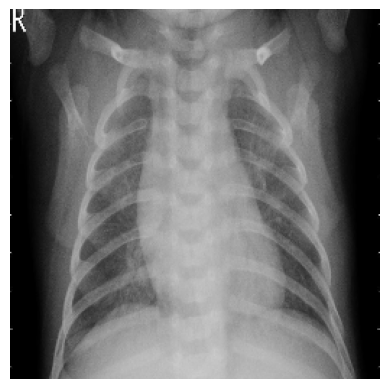

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [17]:
# Display different images in the first batch of the training set
train_set_elem = train_set.take(1)
for images, labels in train_set_elem:
  images = images.numpy()
  labels = labels.numpy()

plt.imshow(images[idx]/255.0)
plt.axis('off')
plt.show()

print(f'Training Set Image Label: {labels[idx]}')
print(f'Training Set Image Shape: {images[idx].shape}')

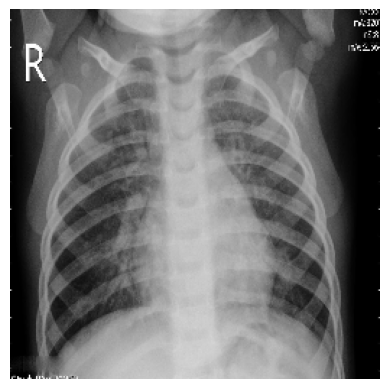

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [18]:
# Do the same thing for the first batch in test set
test_set_elem = test_set.take(1)
for images, labels in test_set_elem:
  images = images.numpy()
  labels = labels.numpy()

idx = 0
plt.imshow(images[idx]/255.0)
plt.axis('off')
plt.show()

print(f'Training Set Image Label: {labels[idx]}')
print(f'Training Set Image Shape: {images[idx].shape}')

* As we can see the X-ray is not centered. From both images we can see the ribs overlapping the lungs inside, and also the heart with a white contrast.

  * First thought: It can be hard extracting the features lung images looking at the overlap. A cmore complex model could perhaps manage to extract relevant features.

* Even though the image looks like all in grayscale, you may notice that the `R` label on upper left--indicating that there are still `3` channels available on `R`, `G`, and `B`.

* While we're looking at the images, we can keep in mind of methods on data augmentation to improve the accuracy later on. Since the lungs are covering most of the pixels, we can do a few to vary the data while retain the images.
  * `RandomFlip('horizontal_and_vertical')`
  * `RandomZoom(height_factor)`
  * `RandomRotation(factor)`





## First Model: Simple CNN I

There's a lot of experimentation involved when it comes to building any deep model. We'll start with the small one--simple Convolutional Neural Network, and then we can work on and add more layers from there.

In [19]:
# `model_cnn`: 1 each of:
##    convolutional, max pooling, flatten, fully-connected, and
##    an output layer with 2 filters for each class names.

model_cnn = models.Sequential()

model_cnn.add(layers.Conv2D(
    filters = 16, kernel_size = (3,3),
    strides = 2, padding = 'valid',
    activation = 'relu',
    input_shape = (256, 256, 3)))
model_cnn.add(layers.MaxPooling2D(
    pool_size = (3,3), strides = 2))
model_cnn.add(layers.Flatten())

model_cnn.add(layers.Dense(16, activation = 'relu'))
model_cnn.add(layers.Dense(2))

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 127, 127, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 63504)             0         
                                                                 
 dense_4 (Dense)             (None, 16)                1016080   
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1016562 (3.88 MB)
Trainable params: 1016562 (3.88 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [20]:
model_cnn.compile(
    optimizer = optimizers.Adam(learning_rate=0.01),
    loss = losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])

model_cnn.fit(train_set_normalized, epochs=5)

test_loss, test_acc = model_cnn.evaluate(test_set_normalized)
print(f'Test set accuracy: {test_acc}')

Epoch 1/5
33/33 [==============================] - 28s 603ms/step - loss: 2.0385 - accuracy: 0.7633
Epoch 2/5
33/33 [==============================] - 28s 657ms/step - loss: 0.2933 - accuracy: 0.8920
Epoch 3/5
33/33 [==============================] - 28s 626ms/step - loss: 0.1827 - accuracy: 0.9310
Epoch 4/5
33/33 [==============================] - 28s 634ms/step - loss: 0.0976 - accuracy: 0.9673
Epoch 5/5
5/5 [==============================] - 4s 116ms/step - loss: 1.2646 - accuracy: 0.7388
Test set accuracy: 0.7387820482254028


## First Model: Simple CNN II

With a result of accuracies that may indicate overfitting, we could try adding layers, tuning hyperparameters first. When it still overfits, we'll introduce some form of regularization and data augmentation in the model to reduce any potential case of overfitting. The sky's the limit when it comes to experimentation.

In [21]:
# `model_cnn_opt`:
## Optimization of the CNN model
## by experimenting on a bunch of factors

model_cnn_opt = models.Sequential()

model_cnn_opt.add(layers.Conv2D(
    filters = 128, kernel_size = (3,3),
    strides = 2, padding = 'valid',
    activation = 'relu',
    input_shape = (256, 256, 3)))
model_cnn_opt.add(layers.MaxPooling2D(
    pool_size = (3,3), strides = 2))

## Add another Conv2D + MaxPooling2D
## with twice filters as previous one.
model_cnn_opt.add(layers.Conv2D(
    filters = 256, kernel_size = (3,3),
    strides = 2, padding = 'valid',
    activation = 'relu',
    input_shape = (256, 256, 3)))
model_cnn_opt.add(layers.MaxPooling2D(
    pool_size = (3,3), strides = 2))

model_cnn_opt.add(layers.Flatten())

## Make 3 Dense layers; 256-64-32,
## with half rate of Dropout after for each
model_cnn_opt.add(layers.Dense(256, activation = 'relu'))
model_cnn_opt.add(layers.Dropout(0.5))

model_cnn_opt.add(layers.Dense(64, activation = 'relu'))
model_cnn_opt.add(layers.Dropout(0.5))

model_cnn_opt.add(layers.Dense(32, activation = 'relu'))
model_cnn_opt.add(layers.Dropout(0.5))

model_cnn_opt.add(layers.Dense(2))

model_cnn_opt.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 127, 127, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 31, 256)       295168    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 256)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 57600)             0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [24]:
## Compiling model -- `learning_rate` value is decreased from 0.01 to 0.001
model_cnn_opt.compile(
    optimizer = optimizers.Adam(learning_rate=0.001),
    loss = losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])

## Adding a callback in case it will still result in overfitting
callback = callbacks.EarlyStopping(
    monitor='val_loss', patience=3, mode='min')

model_cnn_opt.fit(train_set_normalized, epochs=5, callbacks=[callback],
    validation_data = validation_set_normalized)

test_loss, test_acc = model_cnn_opt.evaluate(test_set_normalized)
print(f'Test set accuracy: {test_acc}')

Epoch 1/5
33/33 [==============================] - 38s 889ms/step - loss: 0.3152 - accuracy: 0.8588 - val_loss: 0.1436 - val_accuracy: 0.9465
Epoch 2/5
33/33 [==============================] - 36s 889ms/step - loss: 0.1976 - accuracy: 0.9264 - val_loss: 0.1239 - val_accuracy: 0.9598
Epoch 3/5
33/33 [==============================] - 36s 893ms/step - loss: 0.1440 - accuracy: 0.9551 - val_loss: 0.1010 - val_accuracy: 0.9637
Epoch 4/5
33/33 [==============================] - 39s 1s/step - loss: 0.1267 - accuracy: 0.9587 - val_loss: 0.1013 - val_accuracy: 0.9503
Epoch 5/5
5/5 [==============================] - 5s 333ms/step - loss: 1.3434 - accuracy: 0.7484
Test set accuracy: 0.7483974099159241


In this model, we change several things:

  * We change the first `filters` in `Conv2D` from `16` to `128`,

  * We add another layer of `Conv2D + MaxPooling2D` with `filters` of `256`--twice as the previous one.

  * We add a total of 3 `Dense` fully-connected layers with nodes of `[256, 128, 32]` respectively.

  * We change `learning_rate` of `Adam` optimizer from `0.01` to `0.001` to get a more accurate performance, and

  * Lastly we add `callbacks.EarlyStopping()` so that the model stops training when the result remains overfitting.

The changes in model results in accuracy of `...%` in training set and `...%` in test set.

## Second Model: Transfer Learning

Other options we can try on building the model with good performance is by taking an existing trained model (hence the term called, pre-trained model), and tweak it to match our dataset--this is called transfer learning.

We'll be using `tf.keras.applications()` with a pre-trained model of `resnet_v2.ResNet50V2` for ResNet50V2 architecture. We can also try other options offered [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications). We'll also pre-process the image according to the pre-trained model used by calling a module of `applications.resnet50.preprocess_input(input_layer)`.

In [26]:
## img_size = 256

# Assign pre-trained model ResNet50
base_model = applications.resnet_v2.ResNet50V2(
    include_top = False, weights = 'imagenet',
    input_shape = (img_size, img_size, 3))

# Freeze all the layers
base_model.trainable = False

input_layer = Input(shape=(img_size, img_size, 3))

# Pre-process the images, and then add data augmentation for variations of images
preprocessed_input_layer = applications.resnet_v2.preprocess_input(input_layer)
preprocessed_input_layer = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
preprocessed_input_layer = layers.RandomRotation(factor=0.2)(preprocessed_input_layer)

features_layer = base_model(preprocessed_input_layer, training = False)
global_pooling = layers.GlobalAveragePooling2D()(features_layer)

# Residual blocks of ResNet50V2:
fc1 = layers.Dense(512)(global_pooling)
fc1 = layers.ReLU()(fc1)

fc2 = layers.Dense(128)(fc1)
fc2 = layers.ReLU()(fc2)

fc3 = layers.Dense(32)(fc2)
fc3 = layers.ReLU()(fc3)

output = layers.Dense(2)(fc3)

model_resnet50v2 = Model(inputs=input_layer, outputs=output)

model_resnet50v2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                             

In [27]:
## Unfreeze the layers, freeze all besides ones we're changing
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

## Compiling model -- `learning_rate` value is decreased from 0.01 to 0.001
model_resnet50v2.compile(
    optimizer = optimizers.Adam(learning_rate=0.001),
    loss = losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])

## Adding a callback in case it will still result in overfitting
model_resnet50v2.fit(train_set_normalized, epochs=5, callbacks=[callback],
    validation_data = validation_set_normalized)

test_loss, test_acc = model_resnet50v2.evaluate(test_set_normalized)
print(f'Test set accuracy: {test_acc}')

Epoch 1/5
33/33 [==============================] - 75s 2s/step - loss: 0.6190 - accuracy: 0.7002 - val_loss: 0.4976 - val_accuracy: 0.7629
Epoch 2/5
33/33 [==============================] - 42s 1s/step - loss: 0.4596 - accuracy: 0.7762 - val_loss: 0.3806 - val_accuracy: 0.8509
Epoch 3/5
33/33 [==============================] - 41s 1s/step - loss: 0.3525 - accuracy: 0.8325 - val_loss: 0.3133 - val_accuracy: 0.8585
Epoch 4/5
33/33 [==============================] - 43s 1s/step - loss: 0.3526 - accuracy: 0.8335 - val_loss: 0.3479 - val_accuracy: 0.8289
Epoch 5/5
5/5 [==============================] - 13s 2s/step - loss: 0.3967 - accuracy: 0.8413
Test set accuracy: 0.8413461446762085


Testing a model of ResNet50v2 results in training and test accuracy of both `84.13%`.

## Evaluating on the Test Set

Now let's look at how the model performs in test dataset.

In [28]:
(simple_cnn_test_loss,
 simple_cnn_test_acc)     = model_cnn.evaluate(test_set_normalized)
print(f'Test set accuracy: {simple_cnn_test_acc}')

(optimized_cnn_test_loss,
 optimized_cnn_test_acc)  = model_cnn_opt.evaluate(test_set_normalized)
print(f'Test set accuracy: {optimized_cnn_test_acc}')

(resnet50v2_test_loss,
 resnet50v2_test_acc)     = model_resnet50v2.evaluate(test_set_normalized)
print(f'Test set accuracy: {resnet50v2_test_acc}')

5/5 [==============================] - 3s 70ms/step - loss: 1.2646 - accuracy: 0.7388
Test set accuracy: 0.7387820482254028
5/5 [==============================] - 3s 99ms/step - loss: 1.3434 - accuracy: 0.7484
Test set accuracy: 0.7483974099159241
5/5 [==============================] - 5s 405ms/step - loss: 0.3967 - accuracy: 0.8413
Test set accuracy: 0.8413461446762085


The model of ResNet50V2 from transfer learning has higher test accuracy of `84.13%` compared to our CNN model. That being said, the accuracy of either models may not be high enough to be suitable for medical diagnosis. However, we can utilize the model of transfer learning for more development resulting in better performance.